# Init Working Directory

In [920]:
import os

cwd = os.getcwd()

if cwd.endswith('prototype'):
    PATH = os.path.join('..', 'data', 'handwritten-hanacaraka')
    os.chdir(PATH)
    new_cwd = os.getcwd()

    print(f"The current working directory was: {cwd}")
    print(f"It has been changed to: {new_cwd}")

else:
    print(f"The current working directory is: {cwd}")

The current working directory is: C:\Users\Helmy\hanacaraka-classifier\data\clean-hanacaraka


# Removing Corrupted Datas

In [921]:
from PIL import Image

subdirs = [d for d in os.listdir() if os.path.isdir(d)]

image_files = []
for subdir in subdirs:
    image_files.extend([os.path.join(subdir, f) for f in os.listdir(subdir) if f.endswith('.png')])

print(f'Number of image files: {len(image_files)}\n')

Number of image files: 1562



In [922]:
corrupted_files = []
for image_file in image_files:
    try:
        img = Image.open(image_file)
    except:
        corrupted_files.append(image_file)

print(f'Number of corrupted files: {len(corrupted_files)}\n')

Number of corrupted files: 0



In [923]:
image_files = [f for f in image_files if f not in corrupted_files]

print(f'Number of image files after removing corrupted files: {len(image_files)}\n')

Number of image files after removing corrupted files: 1562



# Create New Directory for Selected Datas (Non-corrupted)

In [924]:
import shutil
import os


if (os.getcwd().endswith('handwritten-hanacaraka') 
        or not 
        os.path.exists(os.path.join('..', 'clean-hanacaraka'))):
    new_dir = os.path.join('..', 'clean-hanacaraka')

    for image_file in image_files:
        if os.name == 'nt':
            subdir, filename = image_file.split('\\')
        else:
            subdir, filename = image_file.split('/')
        subdir_path = os.path.join(new_dir, subdir)
        os.makedirs(subdir_path, exist_ok=True)
        new_filename = f'{subdir}_{len(os.listdir(subdir_path)) + 1}.png'
        shutil.copy(image_file, os.path.join(subdir_path, new_filename))

change the working directory to the new directory

In [925]:
os.chdir(new_dir)
new_cwd = os.getcwd()

print(f"The current working directory were: {new_cwd}")

The current working directory were: C:\Users\Helmy\hanacaraka-classifier\data\clean-hanacaraka


# Image Preprocessing

In [926]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

the image were not clean, so we need to preprocess the image. Example of unclean image:

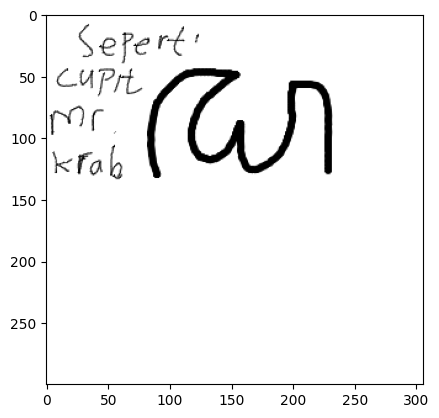

In [927]:
sample_img = ("dha\dha_21.png")
sample_img = cv2.imread(sample_img, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_img, cmap='gray')
plt.show()

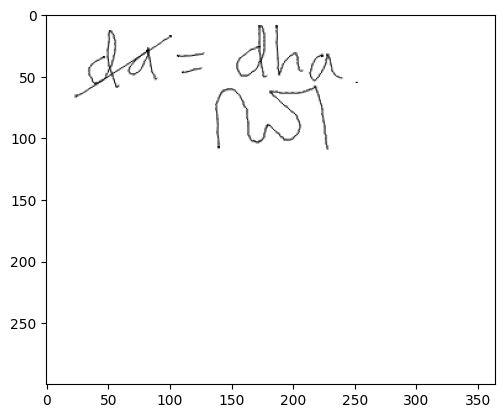

In [928]:
sample_img = ("dha\dha_37.png")
sample_img = cv2.imread(sample_img, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_img, cmap='gray')
plt.show()

function for preprocess the image

In [929]:
def cvt_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [930]:
def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.erode(img, kernel, iterations=1)

In [931]:
def normalize_img(img):
    return (img / 255.0 * 255).astype(np.uint8)

pipeline for preprocess the image

In [932]:
preprocess_timeline = [
    cvt_grayscale,
    erode_img,
    normalize_img,
]

In [933]:
def preprocess_img(path):
    image_file = cv2.imread(path)
    num_of_process = len(preprocess_timeline) + 1
    
    fig, axs = plt.subplots(num_of_process, 1, figsize=(5, 5*num_of_process))
    fig.suptitle('Preprocessing Timeline',                 
                 fontsize=20,
                 fontweight='bold',
                 )
    
    axs[0].imshow(image_file, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    for i in range(1, num_of_process):
        _temp_img = preprocess_timeline[i-1](image_file)
        image_file = _temp_img
        axs[i].imshow(_temp_img, cmap='gray')
        axs[i].set_title(preprocess_timeline[i-1].__name__)
        axs[i].axis('off')
        
    fig.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
    
    for ax in axs:
        ax.set_title(ax.get_title(), fontweight='semibold', fontsize='x-large')
        ax.label_outer()

    plt.subplots_adjust(top=0.95)

    plt.show()

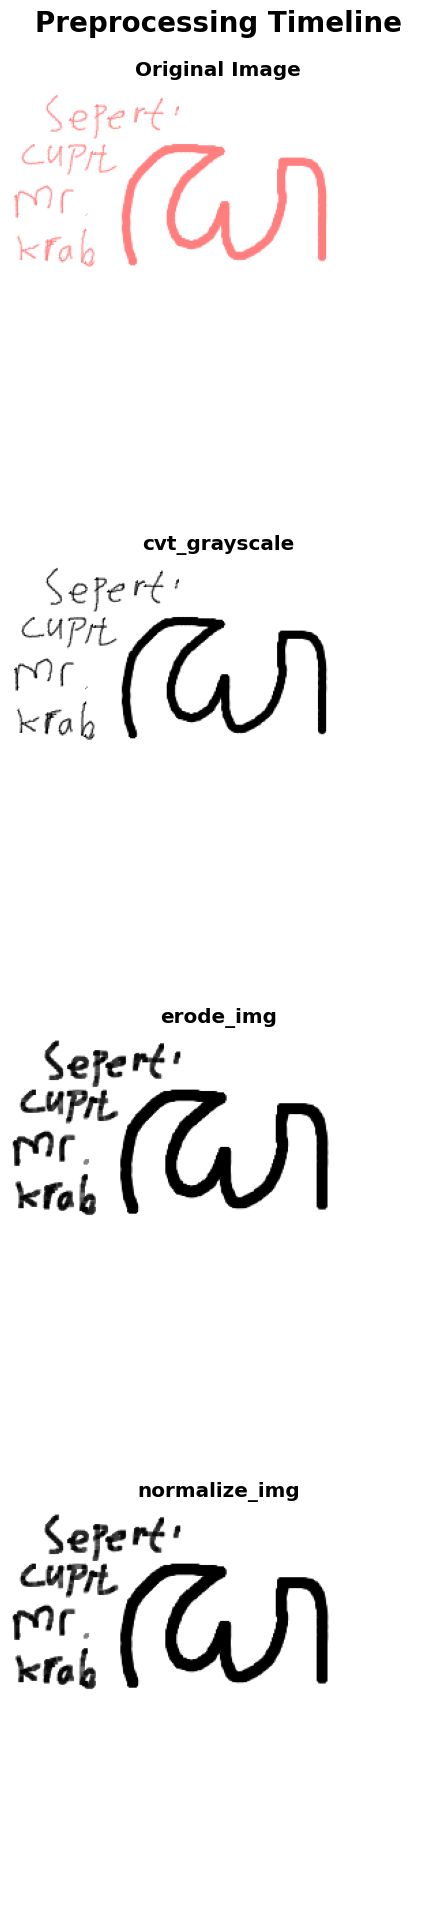

In [934]:
sample_img = ("dha\dha_21.png")

preprocess_img(sample_img)

# Computer Vision Timee

The baseline model will be cnn, so we need to do lot of data augmentation to the image

In [935]:
import torchvision.transforms as transforms
import torch.nn
import torch
import torch.optim
import torch.nn.functional as F
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

Create Dataset Class

the data were multi class, so we need to encode the label. We will use one hot encoding for this. The label will be the index of the class. Dont forget to save it as dictionary for later use

the folder will be like this

{label}/{image_name}.png // ba/ba_1.png

In [936]:
image_names, labels = [], []
for subdir in os.listdir():
    for image_name in os.listdir(subdir):
        image_names.append(image_name)
        labels.append(subdir)

label_dict = {label: i for i, label in enumerate(set(labels))}
label_dict

{'ma': 0,
 'na': 1,
 'ca': 2,
 'dha': 3,
 'ya': 4,
 'nya': 5,
 'ka': 6,
 'ta': 7,
 'ja': 8,
 'tha': 9,
 'ga': 10,
 'wa': 11,
 'sa': 12,
 'pa': 13,
 'ra': 14,
 'la': 15,
 'nga': 16,
 'ba': 17,
 'ha': 18,
 'da': 19}

In [937]:
import pandas as pd

df = pd.DataFrame({'image_name': image_names, 'label': labels})

In [938]:
df.head()

,image_name,label
0,ba_1.png,ba
1,ba_10.png,ba
2,ba_11.png,ba
3,ba_12.png,ba
4,ba_13.png,ba


In [939]:
X_train, x_val, y_train, y_val = train_test_split(
    df['image_name'], df['label'],
    test_size=0.2, random_state=42,
    stratify=df['label']
)

X_val, X_test, y_val, y_test = train_test_split(
    x_val, y_val,
    test_size=0.5, random_state=42,
    stratify=y_val
)

X_train = X_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.shape, x_val.shape, X_test.shape

((1249,), (313,), (157,))

In [940]:
class HanacarakaDataset(Dataset):
    def __init__(self, x, y, maps_label=label_dict, transform=None):
        self.X = x
        self.y = y
        self.dicts = maps_label
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(str(self.y[idx]) + '/' + str(self.X[idx]))
        label = self.y[idx]
        label = self.get_label(label)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def get_label(self, idx):
        label_id = None
        for key, values in self.dicts.items():
            if idx == key:
                label_id = values
        return label_id

    def __len__(self):
        return len(self.X)

In [941]:
def cvt_grayscale(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    return Image.fromarray(img)

def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    img = cv2.erode(np.array(img), kernel, iterations=1)
    return Image.fromarray(img)

def adaptive_threshold(img):
    img = cv2.adaptiveThreshold(np.array(img), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(img)
    
train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    transforms.Lambda(erode_img),
    transforms.Lambda(adaptive_threshold),
    transforms.RandomRotation(10, fill=255),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=255,scale=(0.9, 1.1)),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    transforms.Lambda(erode_img),
    transforms.Lambda(adaptive_threshold),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = HanacarakaDataset(X_train, y_train, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = HanacarakaDataset(X_val, y_val, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = HanacarakaDataset(X_test, y_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [942]:
feature, label = next(iter(train_loader))
feature.shape, len(train_loader)

(torch.Size([64, 1, 100, 100]), 20)

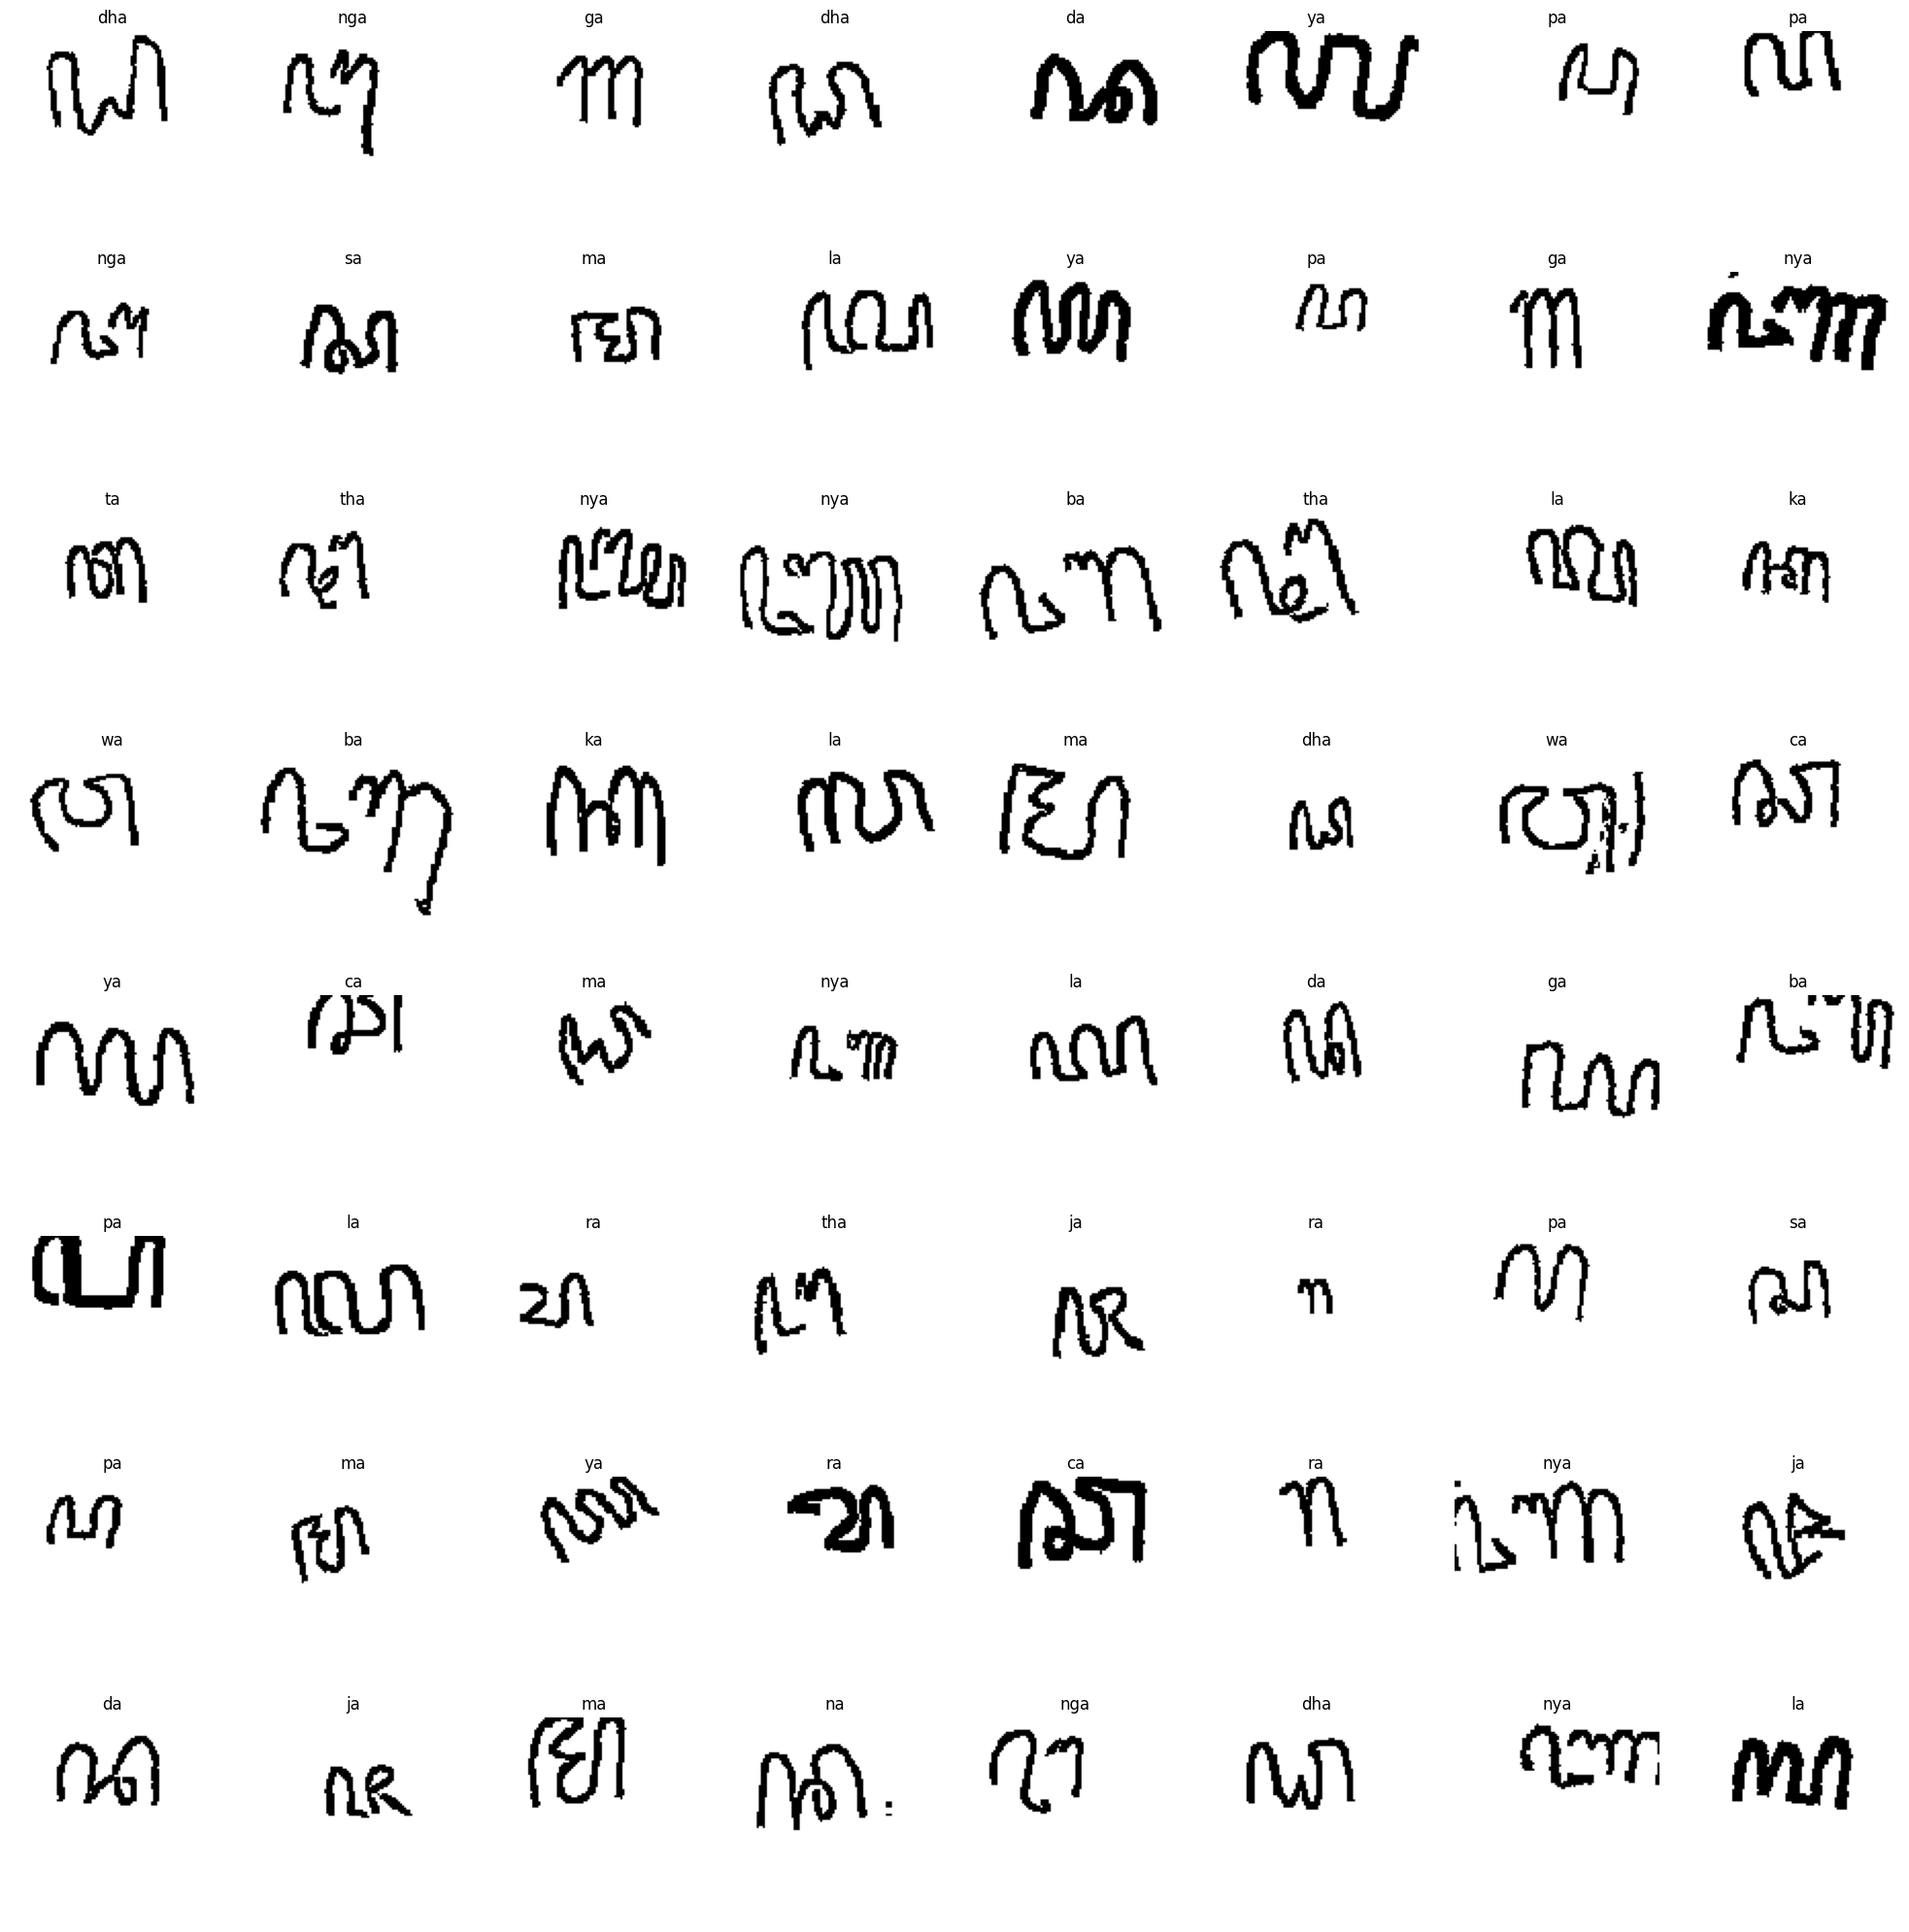

In [943]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20))

for img, label, ax in zip(feature, label, axs.flatten()):
    ax.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
    ax.axis('off')
    label = list(label_dict.keys())[list(label_dict.values()).index(label)]
    ax.set_title(label)
    
plt.tight_layout()
plt.show()